<a href="https://colab.research.google.com/github/ai-fast-track/icevision/blob/timm_mmdet_support/notebooks/timm_mmdet_integration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
!bash install_colab.sh

In [ ]:
# !pip install git+git://github.com/airctic/icevision.git@timm_mmdet_support --upgrade
!rm -rf icevision/
!git clone https://github.com/ai-fast-track/icevision.git -b timm_mmdet_support 
!pip install -e icevision[all] --upgrade -q

In [ ]:
# restart notebook
!kill -9 -1

## Imports

In [25]:
# Imports
from icevision.all import *

## Download and prepare a dataset

In [ ]:
# Download the dataset
url = "https://cvbp-secondary.z19.web.core.windows.net/datasets/object_detection/odFridgeObjects.zip"
dest_dir = "fridge"
data_dir = icedata.load_data(url, dest_dir)

## Parse the dataset

In [5]:
# Create the parser
parser = parsers.VOCBBoxParser(annotations_dir=data_dir / "odFridgeObjects/annotations", images_dir=data_dir / "odFridgeObjects/images")

In [ ]:
# Parse annotations to create records
train_records, valid_records = parser.parse()
parser.class_map

In [7]:
# Transforms
# size is set to 384 because EfficientDet requires its inputs to be divisible by 128
image_size = 384
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=image_size, presize=512), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(image_size), tfms.A.Normalize()])

In [8]:
# Datasets
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

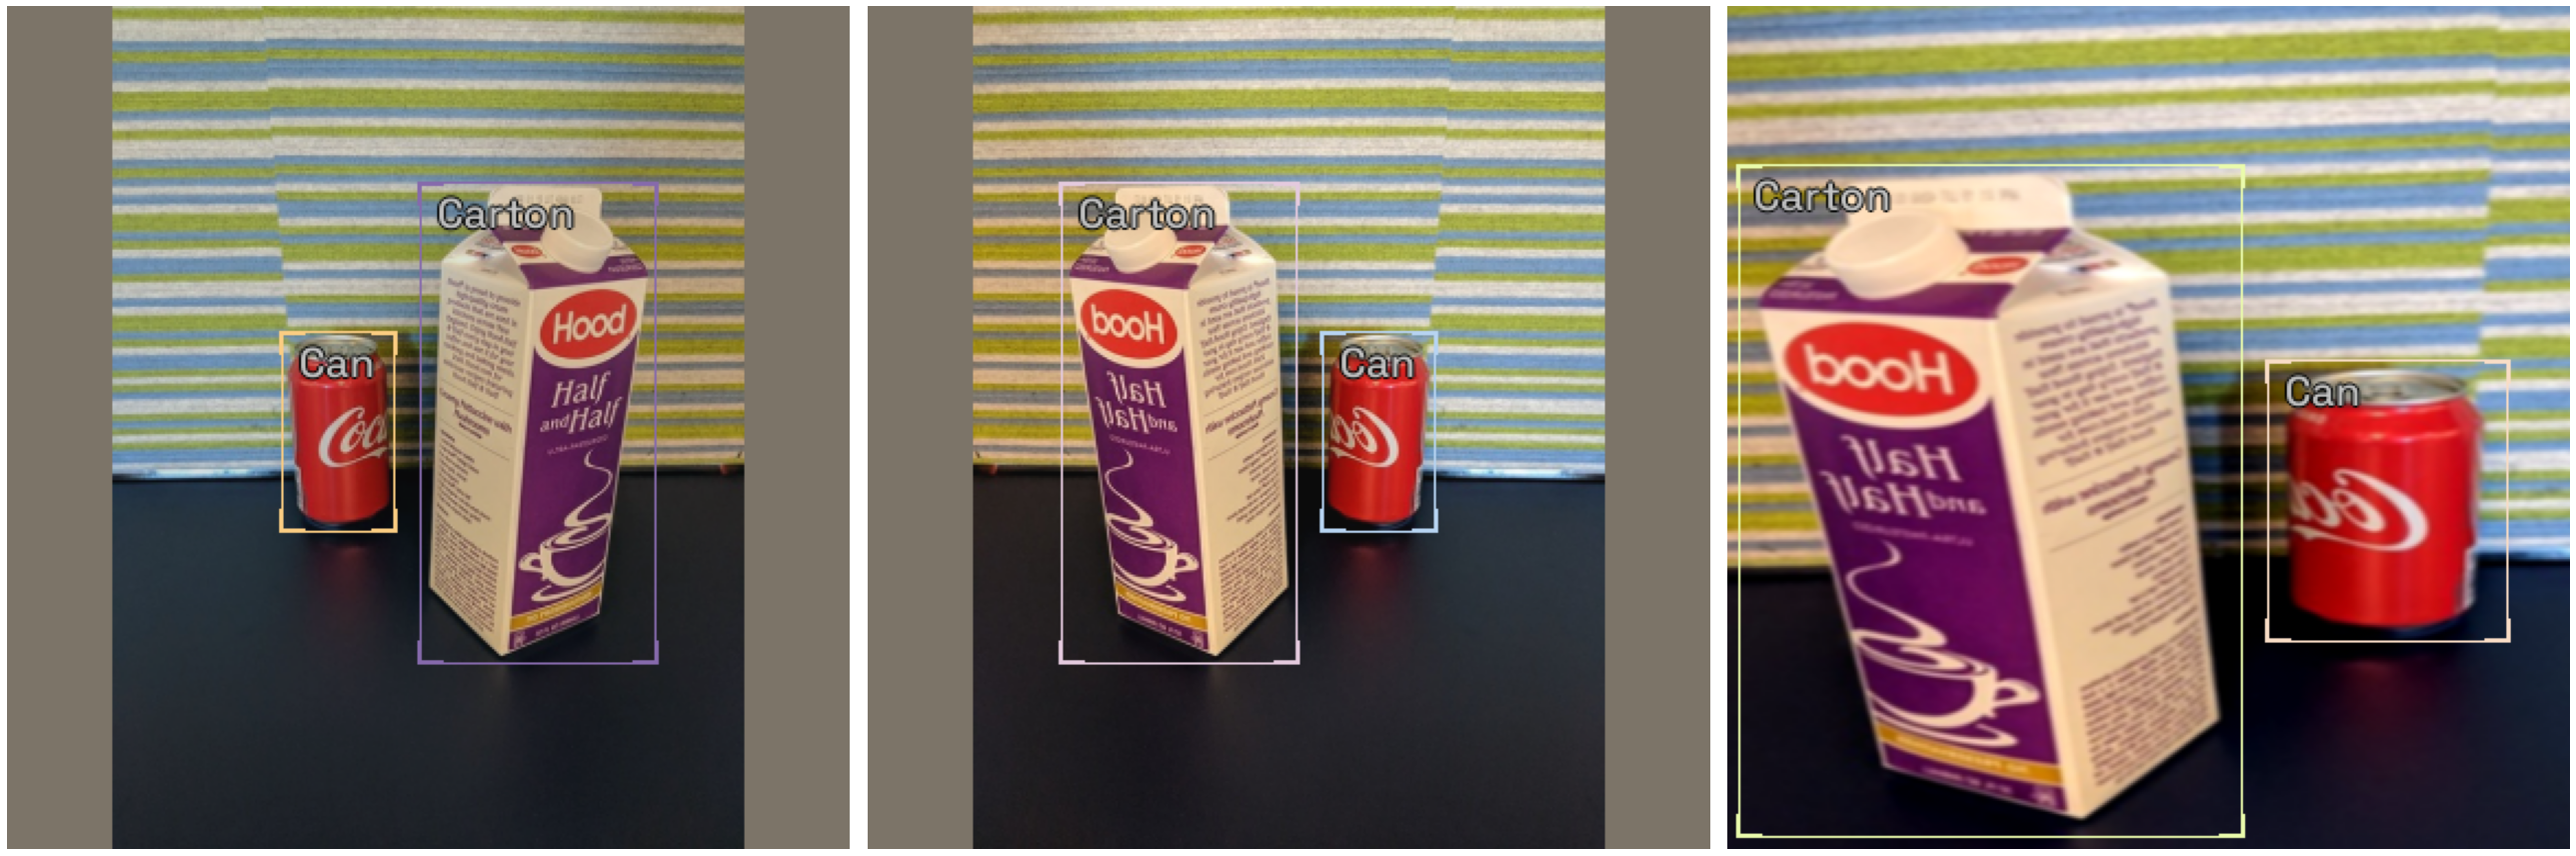

In [9]:
# Show an element of the train_ds with augmentation transformations applied
samples = [train_ds[0] for _ in range(3)]
show_samples(samples, ncols=3)

## Model

## Select an `mmdet` model, and a `timm` backbone

Using IceVision, creating `mmdet` models with `timm` backbone is pretty straightforward. It is similar to creating mmdet models using the original mmdet backbones. 

The advantage of using `timm` backbones is the access to hundred of (pretrained) backbones.

All the models are instantiated as follow:
```
# Instantiate the model
model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(parser.class_map))
```
They are different ways to plug `timm` backbones to `mmdet` models. 

- Since RetinaNet is fully implemented, we  can create  different backbone with one line. Here is an example with **mobilenetv3_large_100**:
```
backbone = model_type.backbones.timm.mobilenet.mobilenetv3_large_100
```

The FCOS model is partially wired to `timm` backbones. However, we can easily plug `timm` backbones using the following options:

- By using default values. We only pass the class of the backbone: `ResNet50_Timm`
```
backbone = MMDetTimmBackboneConfig(
                model_name="fcos",
                config_path="fcos_r50_caffe_fpn_gn-head_1x_coco.py",
                backbone_dict={
                    "type": "ResNet50_Timm",
                },
            )
```

- Or by bxplicitly providing all the parameters:
```
backbone = MMDetTimmBackboneConfig(
                model_name="fcos",
                config_path="fcos_r50_caffe_fpn_gn-head_1x_coco.py",
                backbone_dict={
                    "type": "ResNet50_Timm",
                    "pretrained": True,
                    "out_indices": (2, 3, 4),
                    "norm_eval": True,
                    "frozen_stem": True,
                    "frozen_stages": 1,
                },
                weights_url="https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet50_ram-a26f946b.pth",
            ),
```

In [27]:
from icevision.models.mmdet.utils import *

In [28]:
# Just change the value of selection to try another model

selection = 3

extra_args = {}

# SHOWN FOR COMPARISON PURPOSES
if selection == 0:
  # mmdet retinanet model
  model_type = models.mmdet.retinanet
  # default **mmdet** resnet **backbone**
  backbone = model_type.backbones.resnet50_fpn_1x

## ILLUSTRATION OF MMDETECTION + TIMM INTEGRATION
# MMDetection RetinaNet is fully support: No need to use MMDetTimmBackboneConfig object like in other models such as FCOS, etc.  
elif selection == 1:
  # mmdet retinanet model
  model_type = models.mmdet.retinanet
  # mobilenetv3 **timm** backbones. 
  # Please check out the other supported mobilenetv3 timm backbones
  backbone = model_type.backbones.timm.mobilenet.mobilenetv3_large_100

elif selection == 2:
  # mmdet retinanet model
  model_type = models.mmdet.retinanet
  # resnet **timm** backbones. 
  # Please check out the other supported **resnet/resne(s)t** timm backbones
  backbone = model_type.backbones.timm.resnet.resnetrs50

# For other model other than RetinaNet (e.g FCOS), use MMDetTimmBackboneConfig object
elif selection == 3:
  # mmdet **FCOS** model
  model_type = models.mmdet.fcos
  # resnet **timm** backbones. 
  # Please check out the other supported **resnet/resne(s)t/mobilenetv3** timm backbones
  # Using default parameters
  backbone = MMDetTimmBackboneConfig(
                model_name="fcos",
                config_path="fcos_r50_caffe_fpn_gn-head_1x_coco.py",
                backbone_dict={
                    "type": "ResNet50_Timm",
                },
            )
  
elif selection == 4:
  # mmdet **FCOS** model
  model_type = models.mmdet.fcos
  # resnet **timm** backbones. 
  # Please check out the other supported **resnet/resne(s)t/mobilenetv3** timm backbones
  # Explicitly providing all the parameters
  backbone = MMDetTimmBackboneConfig(
                model_name="fcos",
                config_path="fcos_r50_caffe_fpn_gn-head_1x_coco.py",
                backbone_dict={
                    "type": "ResNet50_Timm",
                    "pretrained": True,
                    "out_indices": (2, 3, 4),
                    "norm_eval": True,
                    "frozen_stem": True,
                    "frozen_stages": 1,
                },
                weights_url="https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet50_ram-a26f946b.pth",
            ),
  

model_type, backbone, extra_args

(<module 'icevision.models.mmdet.models.fcos' from '/content/icevision/icevision/models/mmdet/models/fcos/__init__.py'>,
 {})

In [29]:
# Data Loaders
train_dl = model_type.train_dl(train_ds, batch_size=32, num_workers=2, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=32, num_workers=2, shuffle=False)

In [30]:
backbone.config_path

Path('/root/.icevision/mmdetection_configs/mmdetection_configs-2.10.0/configs/fcos/fcos_r50_caffe_fpn_gn-head_1x_coco.py')

In [31]:
# Instantiate the model
model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(parser.class_map), **extra_args) 

/usr/local/lib/python3.7/dist-packages/mmcv/cnn/utils/weight_init.py:119: UserWarning: init_cfg without layer key, if you do not define override key either, this init_cfg will do nothing
  'init_cfg without layer key, if you do not define override'


loading default pretrained weights: https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet50_ram-a26f946b.pth


  0%|          | 0/102488165 [00:00<?, ?B/s]

Use load_from_local loader
The model and loaded state dict do not match exactly

unexpected key in source state_dict: conv1.weight, bn1.weight, bn1.bias, bn1.running_mean, bn1.running_var, bn1.num_batches_tracked, layer1.0.conv1.weight, layer1.0.bn1.weight, layer1.0.bn1.bias, layer1.0.bn1.running_mean, layer1.0.bn1.running_var, layer1.0.bn1.num_batches_tracked, layer1.0.conv2.weight, layer1.0.bn2.weight, layer1.0.bn2.bias, layer1.0.bn2.running_mean, layer1.0.bn2.running_var, layer1.0.bn2.num_batches_tracked, layer1.0.conv3.weight, layer1.0.bn3.weight, layer1.0.bn3.bias, layer1.0.bn3.running_mean, layer1.0.bn3.running_var, layer1.0.bn3.num_batches_tracked, layer1.0.downsample.0.weight, layer1.0.downsample.1.weight, layer1.0.downsample.1.bias, layer1.0.downsample.1.running_mean, layer1.0.downsample.1.running_var, layer1.0.downsample.1.num_batches_tracked, layer1.1.conv1.weight, layer1.1.bn1.weight, layer1.1.bn1.bias, layer1.1.bn1.running_mean, layer1.1.bn1.running_var, layer1.1.bn1.num_b

In [32]:
backbone.backbone_dict

{'frozen_stages': 1,
 'frozen_stem': True,
 'norm_eval': True,
 'out_indices': (2, 3, 4),
 'pretrained': True,
 'type': 'ResNet50_Timm'}

## Metrics

In [33]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

## Training

### Training using fastai

In [34]:
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=0.0691830962896347)

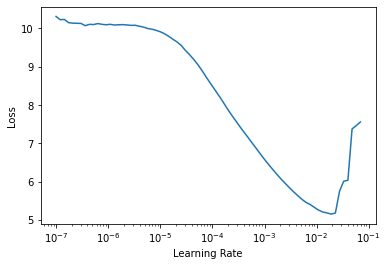

In [35]:
learn.lr_find()

In [36]:
learn.fine_tune(20, 5e-3, freeze_epochs=1)

epoch,train_loss,valid_loss,COCOMetric,time
0,7.339478,4.246834,0.000303,00:04


epoch,train_loss,valid_loss,COCOMetric,time
0,3.388630,2.956713,0.000090,00:04
1,2.919000,2.145956,0.007621,00:04
2,2.686869,2.427049,0.000036,00:04
3,2.548244,1.961621,0.004537,00:04
4,2.424137,1.906791,0.004815,00:04
5,2.336842,2.029226,0.001588,00:04
6,2.295985,1.949652,0.002588,00:04
7,2.244562,2.025139,0.001166,00:04
8,2.195493,1.853776,0.005610,00:04
9,2.168340,1.929671,0.001466,00:04


### Training using Pytorch Lightning

In [37]:
class LightModel(model_type.lightning.ModelAdapter):
    def configure_optimizers(self):
        return SGD(self.parameters(), lr=1e-4)
    
light_model = LightModel(model, metrics=metrics)

In [38]:
trainer = pl.Trainer(max_epochs=20, gpus=1)
trainer.fit(light_model, train_dl, valid_dl)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | FCOS | 32.0 M
-------------------------------
31.8 M    Trainable params
225 K     Non-trainable params
32.0 M    Total params
127.955   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

## Using the model - inference and showing results

The first step in reviewing the model is to show results from the validation dataset. This is easy to do with the `show_results` function.

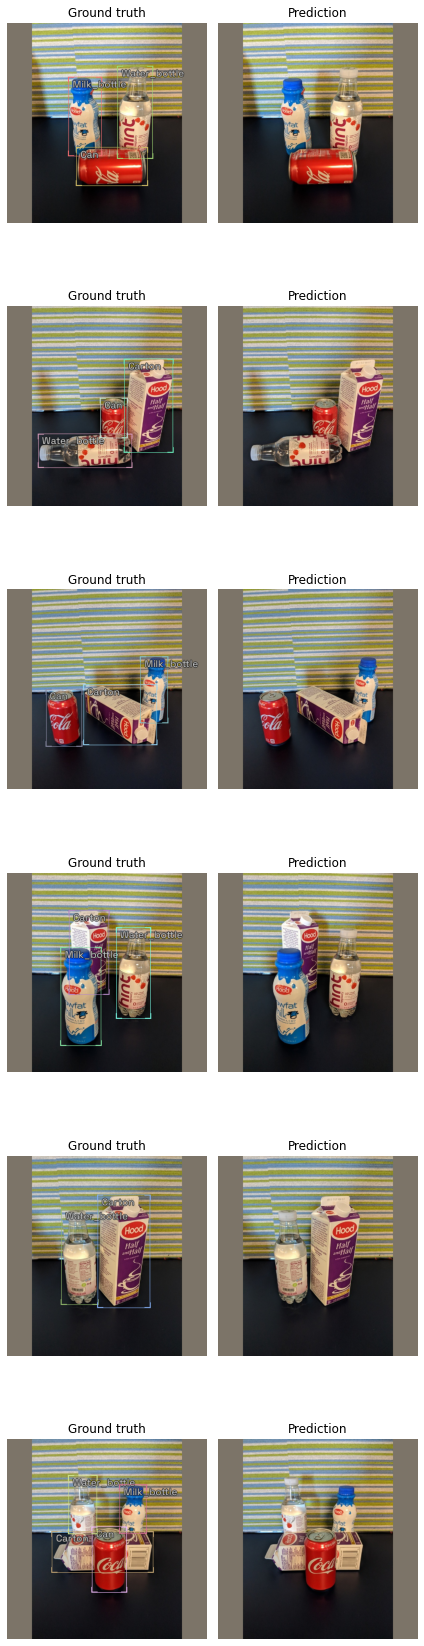

In [39]:
model_type.show_results(model, valid_ds, detection_threshold=.2)

### Prediction

In [ ]:
infer_dl = model_type.infer_dl(valid_ds, batch_size=4, shuffle=False)
preds = model_type.predict_from_dl(model, infer_dl, keep_images=True)

In [ ]:
show_preds(preds=preds[:4])

## Some Timm Stuff

In [ ]:
# !pip install timm

In [40]:
import timm
timm.list_models('*mobile*')

['mobilenetv2_100',
 'mobilenetv2_110d',
 'mobilenetv2_120d',
 'mobilenetv2_140',
 'mobilenetv3_large_075',
 'mobilenetv3_large_100',
 'mobilenetv3_large_100_miil',
 'mobilenetv3_large_100_miil_in21k',
 'mobilenetv3_rw',
 'mobilenetv3_small_075',
 'mobilenetv3_small_100',
 'tf_mobilenetv3_large_075',
 'tf_mobilenetv3_large_100',
 'tf_mobilenetv3_large_minimal_100',
 'tf_mobilenetv3_small_075',
 'tf_mobilenetv3_small_100',
 'tf_mobilenetv3_small_minimal_100']

In [41]:
from timm.models.resnest import *
backbone = resnest50d(
            pretrained=True,
            features_only=True, 
            out_indices=(0, 1, 2, 3, 4),
        )
feature_channels = [o["num_chs"] for o in list(backbone.feature_info)]
feature_channels

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-resnest/resnest50-528c19ca.pth" to /root/.cache/torch/hub/checkpoints/resnest50-528c19ca.pth


[64, 256, 512, 1024, 2048]